##  Monty Hall problem

In this notebook we will explore the Monty Hall problem and we will solve
it using Pyro. You can run the code in this notebook with binder using this
[link](https://mybinder.org/v2/gh/RaulPL/bayesian_statistics_notes/master?filepath=notebooks/monty_hall_pyro.ipynb).

Watch this [video](https://www.youtube.com/watch?v=4Lb-6rxZxx0) if you don't
know about this problem. You can also read more about its history in the
[wikipedia](https://en.wikipedia.org/wiki/Monty_Hall_problem) page.


In [1]:
import daft
import torch
import pyro
import math
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.infer import Importance, EmpiricalMarginal
from typing import Dict, List
from collections import Counter

pyro.set_rng_seed(101)
pyro.enable_validation(True)

At first glance it is not obvious to note that the best strategy is
always to switch to the other door but from the video we learned that this
calculation can be done with pen and paper. Here we are going to solve it with Pyro to see that
we can get to same answer using a probabilistic programming tool.

Pyro requieres that we program the generative process of the problem (the model) using simple annotations. 
Then we condition the model on observed variables (in this case are the constestant's door and
the host's door) with special functions to get a new constrained model, which will be the input to 
an inference algorithm that will calculate a posterior distribution over the
unobserved variable (the prize's door).


The generative process of this problem is the following:
1. The prize is placed behind one of the 3 doors at random. This information
is only available to the host.
2. The contestant select one of the doors without open it. The host observes
the selected door.
3. The host choose a door that doesn't contain the prize and that it is different from
the contestant's door.
4. Finally, the contestan has to choose between keeping her initial choice or
pick the remaining door.


Lets start by programming a function that calculates the probability that
a door will be opened by the host.

In [2]:
def host_conditional_probs(prize_door: int,
                           contestant_door: int) -> List[float]:
    """Given the location of the prize and the contestant's door, 
    the function returns the probabilities over the choices 
    of the host."""
    if prize_door == contestant_door:
        probs = [0.5, 0.5, 0.5]
        probs[contestant_door] = 0.
        return probs
    probs = [1., 1., 1.]
    probs[contestant_door] = 0.
    probs[prize_door] = 0.
    return probs

Now lets test this function in two different scenarios in order to see the possible
choices of the host given the inputs:
* the contestant selects the door with the prize
* the contestant selects a door without the prize

As you can see when the prize and the contestant's door are different the host
has only one possible choice.

In [3]:
# door ∈ {0, 1, 2}
prize_door = 0
contestant_door = 0
assert host_conditional_probs(prize_door, contestant_door) == [0, 0.5, 0.5]

prize_door = 0
contestant_door = 1
assert host_conditional_probs(prize_door, contestant_door) == [0, 0, 1]

We can also describe the problem as a probabilistic graphical model (PGM) where
the location of the prize and the choices made by the contestant and the host
are random variables represented by nodes in the graph below. The edges represent 
dependencies between these variables, and as you can see from the graph the 
choice of the host depends on the location of the prize and the contestant's choice.
In this PGM the nodes that are shaded indicate that the variables are observed (by the contestant,
since it is the person interested in solving the problem).





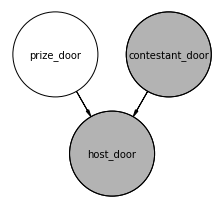

In [4]:
pgm = daft.PGM()
scale = 3
pgm.add_node("prize", "prize_door", 0.5, 2, scale=scale)
pgm.add_node("contestant", "contestant_door", 2.5, 2, scale=scale, observed=True)
pgm.add_node("host", "host_door", 1.5, 0.25, scale=scale, observed=True)
pgm.add_edge("prize", "host")
pgm.add_edge("contestant", "host")
pgm.render();

If your familiar with PGMs you will notice that the graph is a
v-strutucture (collider) which means that if the child node is observed
the parent nodes will become dependent. So it is through the host's choice
that we can learn something about the location of the prize.

Now, lets code the model using Pyro.

In [5]:
def monty_hall_model(contestant_door: int):
    """Monty Hall model"""
    probs_loc_prize = torch.tensor([1/3, 1/3, 1/3])
    # assign the prize to a door with equal probability
    prize_door = pyro.sample('prize_door', dist.Categorical(probs_loc_prize))
    host_probs = host_conditional_probs(int(prize_door), contestant_door)
    host_door = pyro.sample(
        'host_door', dist.Categorical(torch.tensor(host_probs))
    )
    return {'prize_door': prize_door, 'host_door': host_door}


contestant_door = 0
monty_hall_model(contestant_door)

{'prize_door': tensor(1), 'host_door': tensor(2)}

If we run the model multiple times like a normal function we will get feasible
scenarios of the problem. Here the probability distribution of the prize's door is uniform among the
the 3 choices. Lets simulate the model 1000 times and check that it is the case:

In [6]:
n_samples = 1000
samples = [
    monty_hall_model(contestant_door)['prize_door'].item()
    for _ in range(n_samples)
]
counter = Counter(samples)
{f'prob_door_{door}': c/n_samples for door, c in counter.items()}

{'prob_door_0': 0.338, 'prob_door_1': 0.315, 'prob_door_2': 0.347}

But what happens if we condition our model on knowing the value of the host's
choice? We get a new model with additional contrains. In Pyro we can condition a model on 
new data using the pyro.condition poutine.


In [7]:
host_door = 1

# Conditioned model on host's door
cond_model = pyro.condition(
    monty_hall_model, data={"host_door": torch.tensor(host_door)}
)

Now we only need to run an (approximate) inference algorithm to estimate the
posterior distribution of the unobserved variable. We will use importance sampling, which is one of the algorithms available in the library.

In [8]:
contestant_door = 0
# the doors have to be different
assert contestant_door != host_door
# approximate inference
n_samples = 1000
traces = Importance(cond_model, num_samples=n_samples).run(contestant_door)
prize_marginal = EmpiricalMarginal(traces, ["prize_door"])
samples = [prize_marginal().detach().item() for _ in range(n_samples)]

Finally, lets plot the posterior distribution of the location of the prize

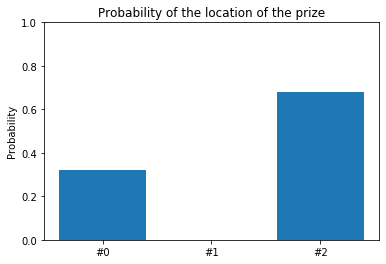

In [9]:
def calculate_posterior_probs(samples: List[int]) -> Dict[int, float]:
    doors = [0, 1, 2]
    counter = Counter(samples)
    probs = {d: counter.get(d, 0) / len(samples) for d in doors}
    return probs


def posterior_plot(probs: Dict[int, float]):
    fig, ax = plt.subplots(1, 1)
    doors = sorted(probs.keys())
    heights = [probs[d] for d in doors]
    ax.bar(doors, heights)
    ax.set_title('Probability of the location of the prize')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)
    plt.xticks(doors, ('#0', '#1', '#2'))


posterior = calculate_posterior_probs(samples)
assert sum(posterior.values()) == 1
assert posterior[1] == 0
assert math.isclose(posterior[2], 2/3, abs_tol=0.03)
posterior_plot(posterior)

From the plot it is possible to see that probability is higher for
door #2 so it is better to switch in order to have a better chance of
finding the prize. Also note that the probability for door #1 is zero,
this makes sense since it is the door chosen by the host.

